\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

As the below realization of the error suggests, considering the mean squared prediction error, mean is a better estimator than median. 

In [1]:
from scipy.stats import expon
from numpy import abs
import numpy as np

mean = 1
median = np.log(2)
n = 1000

rvs = expon.rvs(size=n)

print(((rvs - mean)**2).mean())    # mean squared error of the mean
print(((rvs - median)**2).mean())  # mean squared error of the median

0.9515484415859066
1.0541045208890996


In contrast, considering the mean absolute prediction error, median is a (slightly) better estimator than mean. 

## (b) {-}

In [2]:
rvs = expon.rvs(size=n)

print((abs(rvs - mean)).mean())    # mean absolute error of the mean 
print((abs(rvs - median)).mean())  # mean absolute error of the median

0.74773265119139
0.7076940451049191


# 2. {-}

## (a) {-}

Below is a plot of the loss function 
\begin{align*}
\mathcal L(Y, f(X)) &= b\left(e^{a(Y-f(X))} - a(Y-f(X)) - 1\right) \\
&= b\left(e^{az} - az - 1\right). 
\end{align*}

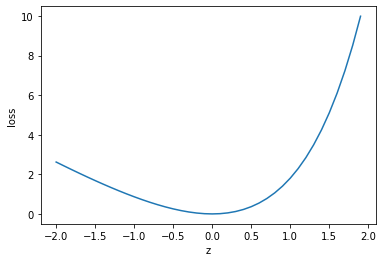

In [3]:
from numpy import exp
from pandas import DataFrame

a = 1.1
b = 2

loss = lambda z: b*(exp(a*z) - a*z -1)
    
ax = DataFrame([(x, loss(x)) for x in np.arange(-2, 2, 0.1)], columns=['z', 'loss']).set_index('z').plot(legend=None)
ax.set_ylabel('loss')
ax.set_xlabel('z');

This is known as the LINEX loss function. Roughly speaking, on the right (when $z>0$) the loss goes up exponentially with the absolute prediction error, while on the left ($z<0$) it only goes up linearly with the absolute prediction error. 

Note that $z = Y - f(X) > 0$ means $f(X)$ underestimates $Y$ while $z<0$ means $f(X)$ overestimates $Y$. We might choose to use this loss function when the consequences of underestimating are much more serious than overestimating. An example could be to estimate a bank's value at risk, where underestimating could result in insufficient reserve and a default event, while the only consequence of overestimating is slight inefficiency in funding and is minor. Another example is to predict the stock price at some point in time in the future and write a naked call option based on that prediction, in which case a serious underestimating of the stock price means the option expires deep in the money and the writer takes a huge loss, while overestimating simply means the writer could have collected more premium by writing an option with a lower strike. 

## (b) {-}

\begin{align}
\mathbb E\mathcal L(Y, f(X)) &= \mathbb E[\mathbb E[ b(e^{a(Y-f(X))} - a(Y-f(X)) -1) |X]]\\
&= \mathbb E[b \mathbb E[e^{a(Y-f(X))}|X] - abE[Y-f(X)|X] -b]\\
&= \mathbb E[b e^{-af(X)}\mathbb E[e^{aY}|X] - abE[Y|X] + abf(X) -b]\\
\end{align}